In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

train_df = pd.read_csv("/Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting/data/preprocessed/resid_train.csv")
val_df = pd.read_csv("/Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting/data/preprocessed/resid_val.csv")
test_df = pd.read_csv("/Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting/data/preprocessed/resid_test.csv")

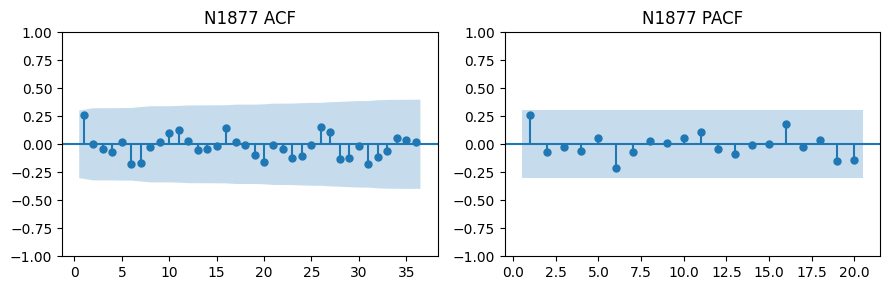

      lb_stat  lb_pvalue
12   8.014006   0.784035
24  15.472797   0.906159


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

sid = "N1877"  # pick a series
res = (pd.concat([val_df, test_df])              # your residual frames
         .query("Series == @sid")
         .sort_values("date")[["date","resid"]]
         .dropna())

y = res["resid"].to_numpy(dtype=float)
y = y - np.nanmean(y)   # center (ACF assumes zero mean)

# plots
lags = 36
fig, ax = plt.subplots(1,2, figsize=(9,3))
plot_acf(y, lags=lags, zero=False, ax=ax[0])
plot_pacf(y, lags=min(lags, len(y)//2-1), method="ywm", zero=False, ax=ax[1])
ax[0].set_title(f"{sid} ACF"); ax[1].set_title(f"{sid} PACF")
plt.tight_layout(); plt.show()

# Ljung–Box test: H0 = white noise (no autocorrelation)
lb = acorr_ljungbox(y, lags=[12, 24], return_df=True)
print(lb)  # look at p-values at 12 and 24

In [3]:
def add_monthly_sinusoids(
    df: pd.DataFrame,
    time_col: str = "date",
    sin_col: str = "sin_p",
    cos_col: str = "cos_p",
) -> pd.DataFrame:
    """
    Add month-of-year sinusoidal features to `df`.

    - Phase = calendar month (Jan=1 .. Dec=12)
    - theta = 2π * (phase-1) / 12
    - Returns a copy of df with two new columns: sin_col, cos_col
    """
    out = df.copy()
    dts = pd.to_datetime(out[time_col], errors="coerce")
    phase = dts.dt.month  # 1..12
    theta = 2.0 * np.pi * (phase - 1) / 12.0
    out[sin_col] = np.sin(theta)
    out[cos_col] = np.cos(theta)
    return out


In [4]:
train_feat = add_monthly_sinusoids(train_df, time_col="date")
val_feat   = add_monthly_sinusoids(val_df,   time_col="date")
test_feat  = add_monthly_sinusoids(test_df,  time_col="date")
train_feat.head()

,Series,date,resid,sin_p,cos_p
0,N1877,1982-01-01,-0.001995,0.000000,1.000000e+00
1,N1877,1982-02-01,-0.006373,0.500000,8.660254e-01
2,N1877,1982-03-01,0.013777,0.866025,5.000000e-01
3,N1877,1982-04-01,0.017648,1.000000,6.123234e-17
4,N1877,1982-05-01,-0.002018,0.866025,-5.000000e-01


In [5]:
def standardize_sin_cos(train_df, val_df, test_df, sin_col="sin_p", cos_col="cos_p"):
    tr_mean_sin, tr_std_sin = train_df[sin_col].mean(), train_df[sin_col].std(ddof=0) or 1.0
    tr_mean_cos, tr_std_cos = train_df[cos_col].mean(), train_df[cos_col].std(ddof=0) or 1.0
    for df in (train_df, val_df, test_df):
        df[sin_col] = (df[sin_col] - tr_mean_sin) / tr_std_sin
        df[cos_col] = (df[cos_col] - tr_mean_cos) / tr_std_cos
    stats = {"sin_p": (tr_mean_sin, tr_std_sin), "cos_p": (tr_mean_cos, tr_std_cos)}
    return train_df, val_df, test_df, stats

In [6]:
train_feat, val_feat, test_feat, stats = standardize_sin_cos(train_feat, val_feat, test_feat)
train_feat.head()

,Series,date,resid,sin_p,cos_p
0,N1877,1982-01-01,-0.001995,-0.036525,1.407395
1,N1877,1982-02-01,-0.006373,0.671075,1.217927
2,N1877,1982-03-01,0.013777,1.189074,0.700293
3,N1877,1982-04-01,0.017648,1.378675,-0.006809
4,N1877,1982-05-01,-0.002018,1.189074,-0.713911


In [7]:
print("VAL sizes per ID:\n", val_feat.groupby("Series").size().sort_values().head())
print("TEST sizes per ID:\n", test_feat.groupby("Series").size().sort_values().head())

VAL sizes per ID:
 Series
N2011    14
N2118    18
N2163    19
N2140    19
N2164    19
dtype: int64
TEST sizes per ID:
 Series
N2011    14
N2118    18
N2163    19
N2140    19
N2164    19
dtype: int64


In [8]:
def add_month_idx(df, date_col="date", out_col="month_idx"):
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col], errors="coerce")
    out[out_col] = out[date_col].dt.month.astype("int16") - 1  # 0..11
    return out

# modify your frames
train_feat = add_month_idx(train_feat)
val_feat   = add_month_idx(val_feat)
test_feat  = add_month_idx(test_feat)
train_feat.head()

,Series,date,resid,sin_p,cos_p,month_idx
0,N1877,1982-01-01,-0.001995,-0.036525,1.407395,0
1,N1877,1982-02-01,-0.006373,0.671075,1.217927,1
2,N1877,1982-03-01,0.013777,1.189074,0.700293,2
3,N1877,1982-04-01,0.017648,1.378675,-0.006809,3
4,N1877,1982-05-01,-0.002018,1.189074,-0.713911,4


In [9]:
import numpy as np
import tensorflow as tf

class WindowGenerator:
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df, label_columns=None,
                 id_col=None, feature_cols=None, batch_size=64):
        # Which column (if any) marks series IDs
        self.id_col = id_col
        # Which columns are numeric features used by the model
        self.feature_cols = feature_cols or list(train_df.columns.drop(id_col, errors='ignore'))

        # Keep raw dataframes
        self.train_df = train_df
        self.val_df   = val_df
        self.test_df  = test_df

        # Labels
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {n: i for i, n in enumerate(label_columns)}
        self.column_indices = {n: i for i, n in enumerate(self.feature_cols)}

        # Window geometry
        self.input_width  = input_width
        self.label_width  = label_width
        self.shift        = shift
        self.total_window_size = input_width + shift

        self.input_slice   = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start   = self.total_window_size - self.label_width
        self.labels_slice  = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        self.batch_size = batch_size

    def __repr__(self):
        return "\n".join([
            f"Total window size: {self.total_window_size}",
            f"Input indices: {self.input_indices}",
            f"Label indices: {self.label_indices}",
            f"Features: {self.feature_cols}",
            f"Label column(s): {self.label_columns}",
            f"ID column: {self.id_col}",
        ])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def _make_dataset_from_array(self, arr, shuffle):
        # need at least total_window_size points
        if len(arr) < self.total_window_size:
            return None
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=arr.astype(np.float32),
            targets=None,
            sequence_length=self.total_window_size,  # <-- FIX
            sequence_stride=1,
            shuffle=False,                           # shuffle after concat
            batch_size=self.batch_size,
        )
        return ds.map(self.split_window)

    def make_dataset(self, df, shuffle=True):
        if self.id_col is None:
            arr = df[self.feature_cols].to_numpy()
            ds = self._make_dataset_from_array(arr, shuffle=False)
            if ds is None:
                raise ValueError(
                    f"Dataset too short: need ≥{self.total_window_size} rows, got {len(arr)}."
                )
            return (ds.shuffle(10_000, reshuffle_each_iteration=True) if shuffle else ds).cache().prefetch(tf.data.AUTOTUNE)

        # per-ID without crossing boundaries
        dsets = []
        # choose your time key; if index is datetime, use it; else change 'date'
        time_key = df.index.name if df.index.name is not None else 'date'
        for _, g in df.sort_values([self.id_col, time_key]).groupby(self.id_col):
            arr = g[self.feature_cols].to_numpy()
            ds_g = self._make_dataset_from_array(arr, shuffle=False)
            if ds_g is not None:
                dsets.append(ds_g)

        if not dsets:
            # No ID in this split is long enough
            raise ValueError(
                f"No groups in split have ≥{self.total_window_size} rows. "
                f"Smallest viable window requires input_width={self.input_width} "
                f"+ shift={self.shift} = {self.total_window_size} points."
            )

        ds = dsets[0]
        for d in dsets[1:]:
            ds = ds.concatenate(d)
        if shuffle: ds = ds.shuffle(10_000, reshuffle_each_iteration=True)
        return ds.cache().prefetch(tf.data.AUTOTUNE)

    @property
    def train(self): return self.make_dataset(self.train_df, shuffle=True)
    @property
    def val(self):   return self.make_dataset(self.val_df,   shuffle=False)
    @property
    def test(self):  return self.make_dataset(self.test_df,  shuffle=False)


In [10]:
H = 18
INPUT_WIDTH = 18
FEATURES = ["resid","sin_p","cos_p", "month_idx"]

w = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=1,
    shift=1,                    
    train_df=train_feat,        # keep Series/date in df if you pass id_col
    val_df=val_feat,
    test_df=test_feat,
    label_columns=["resid"],
    id_col="Series",            # ensures windows don’t cross IDs
    feature_cols=FEATURES,
    batch_size=128
)


n_features = len(FEATURES)
EMB_DIM = 4                  # small, simple
L2 = 1e-4

inp = tf.keras.Input((INPUT_WIDTH, n_features))                # (B, W, 4)

# split: first 3 numeric, last is month_idx (0..11)
num = tf.keras.layers.Lambda(lambda t: t[:, :, :3])(inp)
mon = tf.keras.layers.Lambda(lambda t: tf.cast(t[:, :, 3], tf.int32))(inp)

# month embedding -> (B, W, EMB_DIM)
mon_emb = tf.keras.layers.Embedding(12, EMB_DIM)(mon)

# fuse -> (B, W, 3 + EMB_DIM)
x = tf.keras.layers.Concatenate(axis=-1)([num, mon_emb])

# light stabilization
x = tf.keras.layers.LayerNormalization(axis=-1)(x)

# single LSTM encoder
x = tf.keras.layers.LSTM(64, return_sequences=False,
                         kernel_regularizer=tf.keras.regularizers.l2(L2))(x)

# tiny head
x = tf.keras.layers.Dense(32, activation="relu",
                          kernel_regularizer=tf.keras.regularizers.l2(L2))(x)
y = tf.keras.layers.Dense(1)(x)                      # 1-step AR target

model = tf.keras.Model(inp, y)


# optimizer/compile
opt = tf.keras.optimizers.AdamW(learning_rate=3e-3, weight_decay=1e-4, clipnorm=1.0)
model.compile(optimizer=opt, loss="mse", metrics=["mae"])

# callbacks
clb = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mae", factor=0.5, patience=3, min_lr=1e-5),
    tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=8, restore_best_weights=True),
]

history = model.fit(
    w.train,
    validation_data=w.val,
    epochs=50,
    callbacks=clb,
    verbose=1
)

Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.0189 - mae: 0.0635 - val_loss: 0.2582 - val_mae: 0.2191 - learning_rate: 0.0030
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0167 - mae: 0.0608 - val_loss: 0.2501 - val_mae: 0.2099 - learning_rate: 0.0030
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0163 - mae: 0.0604 - val_loss: 0.2396 - val_mae: 0.2070 - learning_rate: 0.0030
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0162 - mae: 0.0603 - val_loss: 0.2334 - val_mae: 0.2054 - learning_rate: 0.0030
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0162 - mae: 0.0602 - val_loss: 0.2282 - val_mae: 0.2034 - learning_rate: 0.0030
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0161 - mae: 0.0602 - val_loss: 0.2222 - val_mae: 0.2019 - learning_rate: 0.0030
Epoch 7/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0161 - mae: 0.0601 - val_loss: 0.2175 - val_mae: 0.1988 - learning_rate: 0.0030
Epoc

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

def ar_rollout_next_H_with_month(
    model,
    lastW_scaled_df: pd.DataFrame,
    start_next_date,
    H: int,
    W: int,
    *,
    feature_cols=("resid", "sin_p", "cos_p", "month_idx"),
    date_col="date",
    sincos_stats=None,  # {"sin_p": (mean, std), "cos_p": (mean, std)} computed on TRAIN
):
    """
    Autoregressive rollout for H steps using features:
      - resid (predicted recursively)
      - sin_p, cos_p (optionally standardized with `sincos_stats`)
      - month_idx (0..11) as integer index (left unscaled)

    `lastW_scaled_df` must contain the last W rows with these columns.
    Returns a DataFrame with forecasted residuals (scaled space).
    """
    # Future calendar
    dates = pd.date_range(pd.to_datetime(start_next_date), periods=H, freq="MS")
    months = dates.month.to_numpy()                 # 1..12
    month_idx = (months - 1).astype("int32")        # 0..11

    # Future sin/cos (optionally standardize to match training scale)
    theta = 2.0 * np.pi * (months - 1) / 12.0
    sin_f = np.sin(theta).astype(np.float32)
    cos_f = np.cos(theta).astype(np.float32)
    if sincos_stats is not None:
        s_mean, s_std = sincos_stats["sin_p"]; c_mean, c_std = sincos_stats["cos_p"]
        s_std = s_std if s_std else 1.0
        c_std = c_std if c_std else 1.0
        sin_f = ((sin_f - np.float32(s_mean)) / np.float32(s_std)).astype(np.float32)
        cos_f = ((cos_f - np.float32(c_mean)) / np.float32(c_std)).astype(np.float32)

    # Seed window (must include month_idx column already)
    X = lastW_scaled_df[list(feature_cols)].to_numpy(dtype=np.float32).copy()  # (W, F)
    preds = np.zeros(H, dtype=np.float32)

    for h in range(H):
        # 1-step prediction
        yhat = model.predict(X[None, ...], verbose=0)
        yhat = np.asarray(yhat, dtype=np.float32).squeeze()  # scalar
        preds[h] = yhat

        # Build next row in EXACT feature order
        feat_map = {
            "resid": float(yhat),
            "sin_p": float(sin_f[h]),
            "cos_p": float(cos_f[h]),
            "month_idx": float(month_idx[h]),  # model will cast to int in graph if you embed
        }
        next_row = np.array([feat_map[col] for col in feature_cols], dtype=np.float32).reshape(1, -1)
        X = np.vstack([X[1:], next_row])  # slide window

    return pd.DataFrame({"date": dates, "resid_pred_scaled": preds})



MAE (scaled): 0.0225 | sMAPE: 157.42%


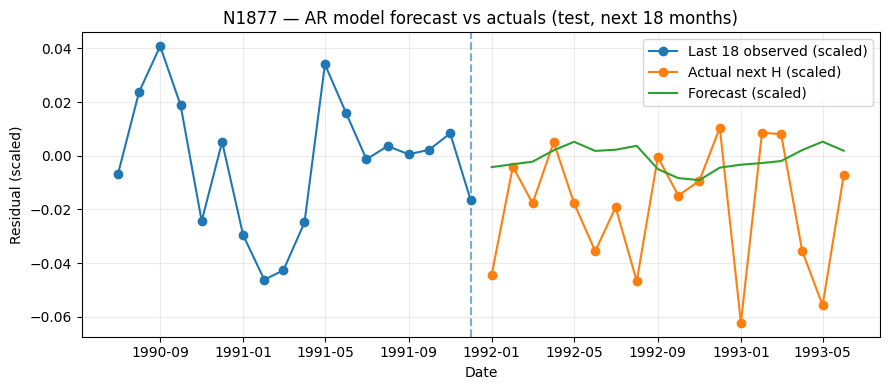

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _ensure_month_idx(df, date_col="date"):
    if "month_idx" in df.columns:
        return df
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col], errors="coerce")
    out["month_idx"] = out[date_col].dt.month.astype("int16") - 1  # 0..11
    return out

def plot_forecast_vs_actuals_AR(model, sid, train_feat, val_feat, test_feat,
                                W=12, H=18, sincos_stats=None, which="test"):
    """
    which='val'  -> history from TRAIN, actuals from VAL
    which='test' -> history from TRAIN+VAL, actuals from TEST
    Requires columns: ['Series','date','resid','sin_p','cos_p','month_idx'].
    Returns (plot_df, {'MAE_scaled':..., 'sMAPE_%':...}) in *scaled* space.
    """
    assert W > 0 and H > 0

    # make sure month_idx exists and dates are tz-naive
    train_feat = _ensure_month_idx(train_feat)
    val_feat   = _ensure_month_idx(val_feat)
    test_feat  = _ensure_month_idx(test_feat)
    for df in (train_feat, val_feat, test_feat):
        df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.tz_localize(None)

    if which == "val":
        prev = train_feat.loc[train_feat["Series"] == sid].sort_values("date")
        fut  = val_feat.loc[val_feat["Series"] == sid].sort_values("date")
    else:
        prev = (pd.concat([train_feat, val_feat], ignore_index=True)
                .loc[lambda d: d["Series"] == sid].sort_values("date"))
        fut  = test_feat.loc[test_feat["Series"] == sid].sort_values("date")

    if prev.empty or fut.empty:
        print("No data for this series in the chosen splits.")
        return None, None

    # history = last W rows from previous split; rollout starts at first date in future split
    hist = prev.tail(W)
    start_next = fut["date"].min()

    # --- AR rollout with month_idx ---
    fc = ar_rollout_next_H_with_month(
        model,
        lastW_scaled_df=hist,
        start_next_date=start_next,
        H=H, W=W,
        feature_cols=("resid","sin_p","cos_p","month_idx"),
        date_col="date",
        sincos_stats=sincos_stats
    )

    # align with ground truth
    gt = fut[["date","resid"]]
    plot_df = fc.merge(gt, on="date", how="left").sort_values("date")
    eval_df = plot_df.dropna(subset=["resid"])

    metrics = {}
    if not eval_df.empty:
        mae = float(np.mean(np.abs(eval_df["resid_pred_scaled"] - eval_df["resid"])))
        smape = float(100.0 * np.mean(
            2*np.abs(eval_df["resid_pred_scaled"] - eval_df["resid"]) /
            (np.abs(eval_df["resid_pred_scaled"]) + np.abs(eval_df["resid"]) + 1e-8)
        ))
        metrics = {"MAE_scaled": mae, "sMAPE_%": smape}
        print(f"MAE (scaled): {mae:.4f} | sMAPE: {smape:.2f}%")
    else:
        print("No overlapping months between forecast and ground truth in this split.")

    # --- plot ---
    obs_tail = prev.tail(W)[["date","resid"]]
    plt.figure(figsize=(9,4))
    plt.plot(obs_tail["date"], obs_tail["resid"], label=f"Last {W} observed (scaled)", marker="o")
    if not eval_df.empty:
        plt.plot(eval_df["date"], eval_df["resid"], label="Actual next H (scaled)", marker="o")
    plt.plot(plot_df["date"], plot_df["resid_pred_scaled"], label="Forecast (scaled)")
    plt.axvline(prev["date"].max(), linestyle="--", alpha=0.6)
    plt.title(f"{sid} — AR model forecast vs actuals ({which}, next {H} months)")
    plt.xlabel("Date"); plt.ylabel("Residual (scaled)")
    plt.grid(alpha=0.25)
    plt.legend(); plt.tight_layout(); plt.show()

    return plot_df, metrics


# call
plot_df, metrics = plot_forecast_vs_actuals_AR(
    model, sid="N1877",
    train_feat=train_feat, val_feat=val_feat, test_feat=test_feat,
    W=INPUT_WIDTH,  # ensure this is the same W you trained with (e.g., 12)
    H=H,
    sincos_stats=stats,   # or whatever your variable is named
    which="test"
)


In [ ]:
# id10 -> 144 , 10 
# id11 -> 144, 10 


# trend -> 100 val -> 20
# 
